<a href="https://colab.research.google.com/github/datapirate09/Lunar-Lander-Reinforcement-Learning/blob/main/deep_q_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!apt install swig
!pip install "gymnasium[box2d]"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [34]:
import gymnasium as gym
env = gym.make("LunarLander-v3", render_mode="rgb_array", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<LunarLander<LunarLander-v3>>>>>

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
from collections import deque

In [36]:
model_current = Sequential([
        tf.keras.layers.InputLayer((8,)),
        tf.keras.layers.Dense(128, activation="relu", name="L1"),
        tf.keras.layers.Dense(128, activation="relu", name="L2"),
        tf.keras.layers.Dense(4),
])

model_current.summary()

model_previous = tf.keras.models.clone_model(model_current)
model_previous.set_weights(model_current.get_weights())

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,180 (71.02 KB)

 Trainable params: 18,180 (71.02 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
import random
actions = [0, 1, 2, 3] # 0- nothing 1 - fire left 2 - fire main 3 - fire right

def epsilon_greedy(state, epsilon):
    if random.random() < epsilon:
        return random.choice(actions)
    else:
        q_values = model_current.predict(np.expand_dims(state, axis=0), verbose=0)[0]
        best_action = np.argmax(q_values)
        return best_action

In [38]:
position, _ = env.reset()
next_state, reward, _, _, _ = env.step(0)
print(next_state)

[ 0.00770121  1.4327478   0.38947675  0.4721913  -0.00882024 -0.0873109
  0.          0.        ]


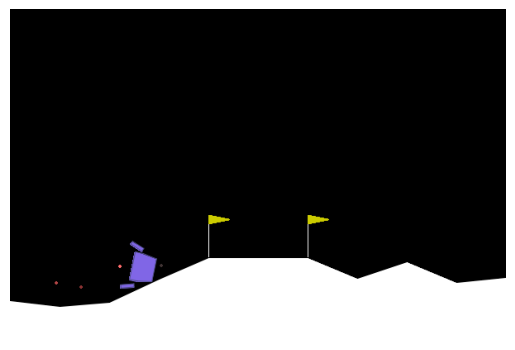

Episode 99 | Epsilon: 0.606


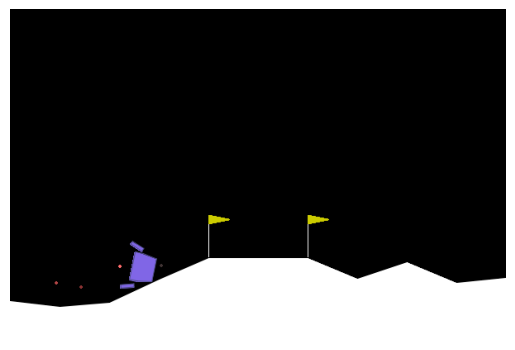

In [45]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

no_of_episodes = 100
gamma = 0.99
replay_memory = deque(maxlen=100_000)
batch_size = 64
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01
target_update_freq = 10
# env.reset()

fig, ax = plt.subplots()

for episode in range(no_of_episodes):
  current_state, _ = env.reset()
  if episode == 99:
    frame = env.render()
    ax.imshow(frame)
    ax.axis('off')
    clear_output(wait=True)
    display(fig)
    time.sleep(0.05)
  end_of_episode = False
  while not end_of_episode:
    action_to_take = epsilon_greedy(current_state, epsilon)
    next_state, reward, terminated, truncated, _ = env.step(action_to_take)
    if episode == 99:
      frame = env.render()
      ax.imshow(frame)
      ax.axis('off')
      clear_output(wait=True)
      display(fig)
      time.sleep(0.05)
    end_of_episode = terminated or truncated
    replay_memory.append((current_state, action_to_take, reward, next_state, end_of_episode))
    current_state = next_state
    if len(replay_memory) >= batch_size:
      mini_batch = random.sample(replay_memory, batch_size)
      states = np.array([x[0] for x in mini_batch])
      actions = np.array([x[1] for x in mini_batch])
      rewards = np.array([x[2] for x in mini_batch])
      next_states = np.array([x[3] for x in mini_batch])
      episode_ends = np.array([x[4] for x in mini_batch])
      q_vals = model_previous.predict(next_states, verbose=0)
      max_qvals = np.max(q_vals, axis=1)
      targets = rewards + (1-episode_ends)*gamma*max_qvals
      with tf.GradientTape() as tape:
        q_values = model_current(states, training=True)
        action_qs = tf.reduce_sum(q_values * tf.one_hot(actions, 4), axis=1)
        loss = loss_fn(targets, action_qs)
      grads = tape.gradient(loss, model_current.trainable_variables)
      optimizer.apply_gradients(zip(grads, model_current.trainable_variables))
  if epsilon > min_epsilon:
    epsilon *= epsilon_decay
    epsilon = max(min_epsilon, epsilon)
  if episode % target_update_freq == 0:
    model_previous.set_weights(model_current.get_weights())

  print(f"Episode {episode} | Epsilon: {epsilon:.3f}")